# Social Network Bayesian Optimization Experiments

This notebook implements Bayesian optimization experiments on social network datasets using graph-based Gaussian processes. We compare multiple algorithms including random search, breadth-first search, and sparse Graph Random Field (GRF) methods for optimizing degree centrality on real-world social networks.

## Setup and Configuration

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch import settings as gsettings
from linear_operator import settings
from linear_operator.utils import linear_cg
from linear_operator.operators import IdentityLinearOperator
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from datetime import datetime
from abc import ABC, abstractmethod

# Add project paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'graph_bo'))

# Import project modules
try:
    from graph_bo.data import graph_data_loader
    from graph_bo.utils import (
        setup_gpytorch_settings, get_device, cleanup_gpu_memory, 
        convert_step_matrices_to_device, get_step_matrices_scipy
    )
    from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
    from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor
    from efficient_graph_gp_sparse.utils_sparse import SparseLinearOperator
    print("✅ All imports successful")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Make sure you're running from the correct directory")

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
output_device = get_device() if 'get_device' in globals() else torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_devices = torch.cuda.device_count()
print(f"Output device: {output_device}, Number of GPUs: {n_devices}")

Cache directory: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/graph_bo/data/processed_data
✅ All imports successful
Output device: cuda:0, Number of GPUs: 2


In [3]:
class SocialBOConfig:
    """Configuration for social network BO experiments"""
    
    def __init__(self):
        # Setup GPyTorch & Linear Operator settings
        self.setup_gpytorch_settings()
        
        # BO parameters
        self.NUM_BO_ITERATIONS = 10
        self.INITIAL_POINTS = 100
        self.BATCH_SIZE = 50
        self.NUM_BO_RUNS = 5
        
        # GRF kernel parameters
        self.WALKS_PER_NODE = 1000
        self.P_HALT = 0.1
        self.MAX_WALK_LENGTH = 3
        
        # Training parameters
        self.LEARNING_RATE = 0.03
        self.TRAIN_EPOCHS = 30
        self.GP_RETRAIN_INTERVAL = 300
        self.PATHWISE_SAMPLES = 64
        
        # Random seeds
        self.BO_SEEDS = [100 + i * 10 for i in range(self.NUM_BO_RUNS)]
        
        # Directories
        base_dir = os.path.dirname(os.path.abspath(os.getcwd()))
        self.STEP_MATRICES_DIR = os.path.join(base_dir, 'data', 'step_matrices')
        self.RESULTS_DIR = os.path.join(base_dir, 'results')
        
        # Create directories
        os.makedirs(self.STEP_MATRICES_DIR, exist_ok=True)
        os.makedirs(self.RESULTS_DIR, exist_ok=True)
    
    def setup_gpytorch_settings(self):
        """Configure GPyTorch settings for large scale experiments"""
        settings.verbose_linalg._default = False
        settings._fast_covar_root_decomposition._default = False
        gsettings.max_cholesky_size._global_value = 0
        gsettings.cg_tolerance._global_value = 1e-2
        gsettings.max_lanczos_quadrature_iterations._global_value = 1
        settings.fast_computations.log_prob._state = True
        gsettings.num_trace_samples._global_value = 64
        gsettings.min_preconditioning_size._global_value = 1e10

# Initialize configuration
config = SocialBOConfig()

# Display key parameters
print(f"📋 Social Network BO Configuration:")
print(f"   BO iterations: {config.NUM_BO_ITERATIONS}")
print(f"   BO runs: {config.NUM_BO_RUNS}")
print(f"   Initial points: {config.INITIAL_POINTS}")
print(f"   Batch size: {config.BATCH_SIZE}")
print(f"   GP retrain interval: {config.GP_RETRAIN_INTERVAL}")
print(f"   Random walks per node: {config.WALKS_PER_NODE}")
print(f"   Max walk length: {config.MAX_WALK_LENGTH}")
print(f"   Results dir: {config.RESULTS_DIR}")
print(f"   Step matrices dir: {config.STEP_MATRICES_DIR}")

📋 Social Network BO Configuration:
   BO iterations: 10
   BO runs: 5
   Initial points: 100
   Batch size: 50
   GP retrain interval: 300
   Random walks per node: 1000
   Max walk length: 3
   Results dir: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/graph_bo/results
   Step matrices dir: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/graph_bo/data/step_matrices


## Data Loading and Preprocessing

In [4]:
def print_dataset_info(dataset_name, A, X, y):
    """Print comprehensive dataset information"""
    n_nodes = A.shape[0]
    n_edges = A.nnz // 2  # Undirected graph
    density = A.nnz / (A.shape[0] * A.shape[1])
    
    print(f"\n📊 Dataset: {dataset_name.upper()}")
    print(f"   Nodes: {n_nodes:,}")
    print(f"   Edges: {n_edges:,}")  
    print(f"   Density: {density:.6f}")
    print(f"   Avg degree: {A.sum(axis=1).mean():.2f}")
    print(f"   Max degree: {int(y.max())}")
    print(f"   Min degree: {int(y.min())}")
    print(f"   Degree std: {y.std():.2f}")

def load_and_preprocess_dataset(dataset_name):
    """Load dataset and preprocess for BO"""
    print(f"🔄 Loading {dataset_name} dataset...")
    
    try:
        # Load dataset
        A, X, y = graph_data_loader(dataset_name)
        
        # Display dataset info
        print_dataset_info(dataset_name, A, X, y)
        
        # Normalize targets for BO (higher degree = better)
        y_normalized = (y - y.mean()) / y.std()
        gt_best_value = float(y_normalized.max())
        gt_best_idx = np.argmax(y_normalized)
        
        print(f"   Normalized best value: {gt_best_value:.4f} (node {gt_best_idx})")
        
        return {
            'A': A,
            'X': X, 
            'y': y,
            'y_normalized': y_normalized,
            'gt_best_value': gt_best_value,
            'gt_best_idx': gt_best_idx,
            'n_nodes': len(X),
            'n_edges': A.nnz // 2,
            'density': A.nnz / (A.shape[0] * A.shape[1])
        }
        
    except Exception as e:
        print(f"❌ Error loading {dataset_name}: {e}")
        return None

# Available datasets
AVAILABLE_DATASETS = ['facebook', 'youtube', 'twitch', 'enron']
print(f"🗂️  Available datasets: {AVAILABLE_DATASETS}")

# Select dataset for this experiment
SELECTED_DATASET = 'facebook'  # Change this to experiment with different datasets
print(f"🎯 Selected dataset: {SELECTED_DATASET}")

# Load and preprocess the selected dataset
dataset_info = load_and_preprocess_dataset(SELECTED_DATASET)

if dataset_info is None:
    print("❌ Failed to load dataset. Please check dataset availability.")
else:
    print(f"✅ Dataset loaded successfully!")

🗂️  Available datasets: ['facebook', 'youtube', 'twitch', 'enron']
🎯 Selected dataset: facebook
🔄 Loading facebook dataset...
Loading facebook from cache...

📊 Dataset: FACEBOOK
   Nodes: 22,470
   Edges: 170,912
   Density: 0.000677
   Avg degree: 15.21
   Max degree: 709
   Min degree: 1
   Degree std: 26.41
   Normalized best value: 26.2658 (node 293)
✅ Dataset loaded successfully!


## Step Matrices Generation and Caching

In [5]:
def get_step_matrices_file_name(base_dir: str,
                dataset: str,
                walks_per_node: int,
                p_halt: float,
                max_walk_length: int,
                random_walk_seed: int) -> str:
    """Create a unique path for storing step matrices."""
    
    dataset_dir = os.path.join(base_dir, dataset)
    os.makedirs(dataset_dir, exist_ok=True)
    return os.path.join(
        dataset_dir,
        f"step_matrices_walks_{walks_per_node}_halt_{p_halt}_maxlen_{max_walk_length}_seed_{random_walk_seed}.pkl"
    )

def load_step_matrices_from_cache(filepath):
    """Load step matrices from cache file"""
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        return data.get('step_matrices_scipy', None), data.get('metadata', {})
    except:
        return None, {}

def save_step_matrices_to_cache(step_matrices_scipy, filepath, metadata):
    """Save step matrices to cache file"""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    save_data = {
        'step_matrices_scipy': step_matrices_scipy,
        'metadata': metadata
    }
    with open(filepath, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"✅ Step matrices cached to: {filepath}")

def preprocess_step_matrices(dataset_name, A, config, use_cache=True):
    """Generate or load step matrices for GRF kernel"""
    
    # Generate cache filepath
    cache_filepath = get_step_matrices_file_name(
        config.STEP_MATRICES_DIR, dataset_name, 
        config.WALKS_PER_NODE, config.P_HALT, config.MAX_WALK_LENGTH, 42
    )
    
    # Try to load from cache
    if use_cache and os.path.exists(cache_filepath):
        print(f"📁 Loading cached step matrices from: {cache_filepath}")
        step_matrices_scipy, metadata = load_step_matrices_from_cache(cache_filepath)
        if step_matrices_scipy is not None:
            print(f"✅ Loaded {len(step_matrices_scipy)} step matrices from cache")
            return step_matrices_scipy
    
    # Generate step matrices
    print(f"🔄 Computing step matrices for {dataset_name}...")
    print(f"   Walks per node: {config.WALKS_PER_NODE}")
    print(f"   Max walk length: {config.MAX_WALK_LENGTH}")
    print(f"   Halt probability: {config.P_HALT}")
    
    pp = GraphPreprocessor(
        adjacency_matrix=A,
        walks_per_node=config.WALKS_PER_NODE,
        p_halt=config.P_HALT,
        max_walk_length=config.MAX_WALK_LENGTH,
        random_walk_seed=42,
        load_from_disk=False,
        use_tqdm=True,
        cache_filename=cache_filepath,
        n_processes=min(10, os.cpu_count())
    )
    
    # Process and get scipy matrices
    pp.preprocess_graph(save_to_disk=False)
    step_matrices_scipy = pp.step_matrices_scipy
    
    # Save to cache
    if use_cache:
        metadata = {
            'dataset': dataset_name,
            'n_nodes': A.shape[0],
            'walks_per_node': config.WALKS_PER_NODE,
            'p_halt': config.P_HALT,
            'max_walk_length': config.MAX_WALK_LENGTH,
            'timestamp': datetime.now().isoformat()
        }
        save_step_matrices_to_cache(step_matrices_scipy, cache_filepath, metadata)
    
    print(f"✅ Generated {len(step_matrices_scipy)} step matrices")
    return step_matrices_scipy

# Generate step matrices for the loaded dataset
if dataset_info is not None:
    print(f"\n🔄 Preprocessing step matrices for {SELECTED_DATASET}...")
    
    step_matrices_scipy = preprocess_step_matrices(
        SELECTED_DATASET, 
        dataset_info['A'], 
        config, 
        use_cache=True
    )
    
    # Convert to device tensors for GPU acceleration
    print(f"🔄 Converting step matrices to device tensors...")
    step_matrices_torch = []
    for mat in step_matrices_scipy:
        tensor = GraphPreprocessor.from_scipy_csr(mat).to(output_device)
        step_matrices_torch.append(SparseLinearOperator(tensor))
    
    print(f"✅ Step matrices ready on {output_device}")
    print(f"   Matrix shapes: {[mat.shape for mat in step_matrices_scipy[:3]]}...")
else:
    print("❌ Cannot generate step matrices - dataset not loaded")


🔄 Preprocessing step matrices for facebook...
🔄 Computing step matrices for facebook...
   Walks per node: 1000
   Max walk length: 3
   Halt probability: 0.1


Process walks: 100%|██████████| 2247/2247 [00:34<00:00, 64.29it/s]
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/efficient_graph_gp_sparse/preprocessor/graph_preprocessor.py:136: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


✅ Step matrices cached to: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/graph_bo/data/step_matrices/facebook/step_matrices_walks_1000_halt_0.1_maxlen_3_seed_42.pkl
✅ Generated 3 step matrices
🔄 Converting step matrices to device tensors...
✅ Step matrices ready on cuda:0
   Matrix shapes: [(22470, 22470), (22470, 22470), (22470, 22470)]...


## Algorithm Implementation

In [6]:
class SparseGraphGPModel(gpytorch.models.ExactGP):
    """Sparse Graph GP Model with pathwise conditioning prediction"""
    
    def __init__(self, x_train, y_train, likelihood, step_matrices_torch, max_walk_length):
        super().__init__(x_train, y_train, likelihood)
        self.x_train = x_train
        self.y_train = y_train
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = SparseGRFKernel(
            max_walk_length=max_walk_length, 
            step_matrices_torch=step_matrices_torch
        )
        self.num_nodes = step_matrices_torch[0].shape[0]
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x_test, n_samples=64):
        """Batch pathwise conditioning prediction"""
        num_train = self.x_train.shape[0]
        train_indices = self.x_train.int().flatten()
        test_indices = x_test.int().flatten()
        
        # Feature matrices
        phi = self.covar_module._get_feature_matrix()
        phi_train = phi[train_indices, :]
        phi_test = phi[test_indices, :]
        
        # Covariance matrices
        K_train_train = phi_train @ phi_train.T
        K_test_train = phi_test @ phi_train.T
        
        # Noise setup
        noise_variance = self.likelihood.noise.item()
        noise_std = torch.sqrt(torch.tensor(noise_variance, device=x_test.device))
        A = K_train_train + noise_variance * IdentityLinearOperator(num_train, device=x_test.device)
        
        # Batch samples
        eps1_batch = torch.randn(n_samples, self.num_nodes, device=x_test.device)
        eps2_batch = noise_std * torch.randn(n_samples, num_train, device=x_test.device)
        
        # Prior samples
        f_test_prior_batch = eps1_batch @ phi_test.T
        f_train_prior_batch = eps1_batch @ phi_train.T
        
        # CG solve
        b_batch = self.y_train.unsqueeze(0) - (f_train_prior_batch + eps2_batch)
        v_batch = linear_cg(A._matmul, b_batch.T, tolerance=gsettings.cg_tolerance.value())
        
        # Posterior
        return f_test_prior_batch + (K_test_train @ v_batch).T

print("✅ SparseGraphGPModel implemented")

✅ SparseGraphGPModel implemented


In [7]:
class Algorithm(ABC):
    """Abstract base class for BO algorithms"""
    
    def __init__(self, n_nodes, device):
        self.n_nodes = n_nodes
        self.device = device
    
    @abstractmethod
    def select_next_point(self, X_observed, Y_observed):
        """Select next point to evaluate"""
        pass
    
    def reset_cache(self):
        """Reset algorithm state - override in subclasses if needed"""
        pass

class RandomSearch(Algorithm):
    """Random search baseline"""
    
    def select_next_point(self, X_observed, Y_observed):
        return np.random.choice(self.n_nodes, 1)[0]
    
    def select_next_points(self, X_observed, Y_observed, batch_size=1):
        """Select multiple points for batch BO"""
        return [np.random.choice(self.n_nodes, 1)[0] for _ in range(batch_size)]

class BFS(Algorithm):
    """Breadth-First Search algorithm for graph exploration"""
    
    def __init__(self, adjacency_matrix, n_nodes, device):
        super().__init__(n_nodes, device)
        self.A = adjacency_matrix
        self.visited = set()
        self.queue = []
    
    def reset_cache(self):
        """Reset BFS state"""
        self.visited = set()
        self.queue = []
    
    def _get_neighbors(self, node_idx):
        """Safely get neighbors from sparse adjacency matrix"""
        try:
            # Get the row for this node, ensuring it's 2D
            row = self.A[node_idx, :]
            neighbors_tuple = row.nonzero()
            
            # Handle both 1D and 2D cases
            if len(neighbors_tuple) == 1:
                # 1D case: nonzero() returns (array([...]),)
                neighbors = neighbors_tuple[0]
            else:
                # 2D case: nonzero() returns (row_indices, col_indices)
                neighbors = neighbors_tuple[1]
            
            return neighbors.flatten()
            
        except Exception as e:
            print(f"Warning: Error getting neighbors for node {node_idx}: {e}")
            return np.array([])
    
    def select_next_point(self, X_observed, Y_observed):
        # Add observed nodes to visited set
        observed_indices = X_observed.cpu().numpy().flatten().astype(int)
        self.visited.update(observed_indices)
        
        # If queue is empty or all neighbors visited, start from best observed node
        if not self.queue:
            best_idx = observed_indices[torch.argmax(Y_observed).item()]
            self.queue = [best_idx]
        
        # BFS exploration
        while self.queue:
            current = self.queue.pop(0)
            # Get neighbors using safe method
            neighbors = self._get_neighbors(current)
            
            for neighbor in neighbors:
                if neighbor not in self.visited:
                    self.visited.add(neighbor)
                    self.queue.append(neighbor)
                    return neighbor
        
        # Fallback to random if no unvisited neighbors
        unvisited = set(range(self.n_nodes)) - self.visited
        if unvisited:
            return np.random.choice(list(unvisited))
        else:
            return np.random.choice(self.n_nodes)

class SparseGRF(Algorithm):
    """Sparse GRF Bayesian Optimization with Thompson Sampling"""
    
    def __init__(self, n_nodes, device, step_matrices, max_walk_length, 
                 learning_rate=0.01, train_epochs=50, retrain_interval=200):
        super().__init__(n_nodes, device)
        self.step_matrices = step_matrices
        self.max_walk_length = max_walk_length
        self.learning_rate = learning_rate
        self.train_epochs = train_epochs
        self.retrain_interval = retrain_interval
        
        # Cache trained model to avoid retraining
        self.cached_model = None
        self.cached_likelihood = None
        self.last_training_size = 0
    
    def reset_cache(self):
        """Reset cached model - call this for each new BO run"""
        self.cached_model = None
        self.cached_likelihood = None
        self.last_training_size = 0
    
    def _should_retrain(self, current_size):
        """Determine if model should be retrained"""
        if self.cached_model is None:
            return True
        if self.retrain_interval == 0:
            return True  # Always retrain
        return (current_size - self.last_training_size) >= self.retrain_interval
    
    def _train_model(self, X_observed, Y_observed):
        """Train or update the GP model"""
        # Create new model
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        model = SparseGraphGPModel(
            X_observed, Y_observed, likelihood, self.step_matrices, self.max_walk_length
        ).to(self.device)
        
        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        
        # Training loop
        for _ in range(self.train_epochs):
            optimizer.zero_grad()
            output = model(X_observed)
            loss = -mll(output, Y_observed)
            loss.backward()
            optimizer.step()
        
        # Cache the trained model
        self.cached_model = model
        self.cached_likelihood = likelihood
        self.last_training_size = len(X_observed)
        
        return model, likelihood
    
    def select_next_points(self, X_observed, Y_observed, batch_size=1):
        """Select multiple points for batch BO"""
        try:
            current_size = len(X_observed)
            
            # Train model if needed
            if self._should_retrain(current_size):
                print(f"    Training GP model (data size: {current_size})")
                model, likelihood = self._train_model(X_observed, Y_observed)
            else:
                print(f"    Using cached GP model (data size: {current_size})")
                model, likelihood = self.cached_model, self.cached_likelihood
            
            # Thompson sampling acquisition
            model.eval()
            likelihood.eval()
            
            X_all = torch.arange(self.n_nodes, dtype=torch.float32, device=self.device).unsqueeze(1)
            
            selected_indices = []
            with torch.no_grad():
                # Generate multiple Thompson samples for batch selection
                for _ in range(batch_size):
                    thompson_samples = model.predict(X_all, n_samples=1)
                    next_idx = torch.argmax(thompson_samples[0, :]).item()
                    selected_indices.append(next_idx)
            
            return selected_indices
            
        except Exception as e:
            print(f"GP failed, falling back to random: {e}")
            return [np.random.choice(self.n_nodes, 1)[0] for _ in range(batch_size)]
    
    def select_next_point(self, X_observed, Y_observed):
        """Single point selection for compatibility"""
        return self.select_next_points(X_observed, Y_observed, batch_size=1)[0]

print("✅ BO algorithms implemented: RandomSearch, BFS, SparseGRF")

✅ BO algorithms implemented: RandomSearch, BFS, SparseGRF


## Bayesian Optimization Framework

In [14]:
class BayesianOptimizer:
    """Master Bayesian Optimization framework with batch sampling support"""
    
    def __init__(self, algorithm, objective_values, initial_points=100, batch_size=50):
        self.algorithm = algorithm
        self.objective_values = objective_values
        self.n_nodes = len(objective_values)
        self.initial_points = initial_points
        self.batch_size = batch_size
        
        # Ground truth best
        self.gt_best_idx = np.argmax(objective_values)
        self.gt_best_value = float(objective_values[self.gt_best_idx])
    
    def run_optimization(self, n_iterations, seed=None, algorithm_name="BO"):
        """Run Bayesian optimization for n_iterations with batching"""
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        results = []
        
        # Initial random sampling
        observed_indices = np.random.choice(self.n_nodes, self.initial_points, replace=False)
        
        X_observed = torch.tensor(observed_indices.reshape(-1, 1), 
                                 dtype=torch.float32, device=self.algorithm.device)
        Y_observed = torch.tensor(self.objective_values[observed_indices].flatten(), 
                                 dtype=torch.float32, device=self.algorithm.device)
        
        best_value = float(Y_observed.max())
        best_idx = observed_indices[torch.argmax(Y_observed).item()]
        
        print(f"    Initial best: {best_value:.4f} at node {best_idx}")
        
        # Optimization loop with progress bar
        with tqdm(range(n_iterations), desc=f"    {algorithm_name} iterations", leave=False) as pbar:
            for iteration in pbar:
                # Select next batch of points
                if hasattr(self.algorithm, 'select_next_points') and self.batch_size > 1:
                    next_indices = self.algorithm.select_next_points(X_observed, Y_observed, self.batch_size)
                else:
                    # Fallback to single point selection
                    next_indices = [self.algorithm.select_next_point(X_observed, Y_observed)]
                
                # Evaluate all points in batch
                batch_results = []
                for batch_idx, next_idx in enumerate(next_indices):
                    next_value = float(self.objective_values[next_idx])
                    
                    # Update best
                    if next_value > best_value:
                        best_value = next_value
                        best_idx = next_idx
                    
                    batch_results.append({
                        'point': next_idx,
                        'value': next_value
                    })
                    
                    # Add to observed data immediately (for dependent sampling)
                    observed_indices = np.append(observed_indices, next_idx)
                
                # Update tensors once per batch
                X_observed = torch.tensor(observed_indices.reshape(-1, 1), 
                                         dtype=torch.float32, device=self.algorithm.device)
                Y_observed = torch.tensor(self.objective_values[observed_indices].flatten(), 
                                         dtype=torch.float32, device=self.algorithm.device)
                
                # Record results for each point in batch
                for batch_idx, batch_result in enumerate(batch_results):
                    results.append({
                        'iteration': iteration + 1,
                        'batch_idx': batch_idx,
                        'next_point': batch_result['point'],
                        'next_value': batch_result['value'],
                        'best_value': best_value,
                        'best_point': best_idx,
                        'regret': self.gt_best_value - best_value,
                        'dataset_size': len(observed_indices)
                    })
                
                # Update progress bar with current best
                pbar.set_postfix({
                    'best': f'{best_value:.4f}',
                    'regret': f'{(self.gt_best_value - best_value):.4f}',
                    'data': len(observed_indices)
                })
                
        # Output the final best result
        print(f"    Final best: {best_value:.4f} at node {best_idx}")
        return results

print("✅ BayesianOptimizer framework implemented")

✅ BayesianOptimizer framework implemented


## Experiment Execution

In [16]:
def run_single_experiment(dataset_info, algorithm_name, config, bo_seed, run_idx):
    """Run a single BO experiment with given algorithm and seed"""
    
    # Create algorithm instance
    if algorithm_name == 'random_search':
        algorithm = RandomSearch(dataset_info['n_nodes'], output_device)
    elif algorithm_name == 'bfs':
        algorithm = BFS(dataset_info['A'], dataset_info['n_nodes'], output_device)
    elif algorithm_name == 'sparse_grf':
        algorithm = SparseGRF(
            dataset_info['n_nodes'], output_device, step_matrices_torch,
            config.MAX_WALK_LENGTH, config.LEARNING_RATE,
            config.TRAIN_EPOCHS, config.GP_RETRAIN_INTERVAL
        )
    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}")
    
    # Reset algorithm state
    algorithm.reset_cache()
    
    # Create optimizer
    optimizer = BayesianOptimizer(
        algorithm, dataset_info['y_normalized'], 
        config.INITIAL_POINTS, config.BATCH_SIZE
    )
    
    # Run optimization
    results = optimizer.run_optimization(
        config.NUM_BO_ITERATIONS, 
        seed=bo_seed, 
        algorithm_name=algorithm_name.replace('_', ' ').title()
    )
    
    # Add metadata to results
    for result in results:
        result.update({
            'algorithm': algorithm_name,
            'dataset': SELECTED_DATASET,
            'bo_seed': bo_seed,
            'bo_run': run_idx + 1,
            'ground_truth_best': dataset_info['gt_best_value'],
            'n_nodes': dataset_info['n_nodes'],
            'n_edges': dataset_info['n_edges'],
            'density': dataset_info['density']
        })
    
    # Cleanup
    del algorithm
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return results

def run_bo_experiments(dataset_info, config, algorithms=['random_search', 'bfs', 'sparse_grf']):
    """Run complete BO experiments across algorithms and seeds"""
    
    if dataset_info is None:
        print("❌ Cannot run experiments - dataset not loaded")
        return None
    
    print(f"\n🎯 Running BO experiments on {SELECTED_DATASET.upper()} dataset")
    print(f"   Algorithms: {algorithms}")
    print(f"   BO iterations: {config.NUM_BO_ITERATIONS}")
    print(f"   BO runs per algorithm: {config.NUM_BO_RUNS}")
    print(f"   Seeds: {config.BO_SEEDS}")
    print(f"   Ground truth best: {dataset_info['gt_best_value']:.4f}")
    
    all_results = []
    
    for algo_name in algorithms:
        print(f"\n🔬 Running {algo_name} with {len(config.BO_SEEDS)} seeds...")
        
        for bo_seed_idx, bo_seed in enumerate(config.BO_SEEDS):
            print(f"   Seed {bo_seed_idx + 1}/{len(config.BO_SEEDS)} (seed={bo_seed})")
            
            try:
                results = run_single_experiment(
                    dataset_info, algo_name, config, bo_seed, bo_seed_idx
                )
                all_results.extend(results)
                
            except Exception as e:
                print(f"❌ Error in {algo_name} run {bo_seed_idx + 1}: {e}")
                continue
    
    if all_results:
        results_df = pd.DataFrame(all_results)
        print(f"\n✅ Experiments completed!")
        print(f"   Total experiments: {len(results_df)}")
        print(f"   Unique algorithms: {sorted(results_df['algorithm'].unique())}")
        return results_df
    else:
        print("❌ No experiments completed successfully")
        return None

# Configure which algorithms to run
ALGORITHMS_TO_RUN = ['random_search', 'bfs', 'sparse_grf']

# Run experiments if dataset and step matrices are ready
if dataset_info is not None and 'step_matrices_torch' in globals():
    print("🚀 Starting Bayesian Optimization experiments...")
    
    bo_results_df = run_bo_experiments(
        dataset_info, 
        config, 
        algorithms=ALGORITHMS_TO_RUN
    )
    
    if bo_results_df is not None:
        print(f"\n📊 Experiment Summary:")
        print(f"   Dataset: {SELECTED_DATASET}")
        print(f"   Total data points: {len(bo_results_df)}")
        print(f"   Algorithms tested: {len(bo_results_df['algorithm'].unique())}")
        print(f"   Runs per algorithm: {config.NUM_BO_RUNS}")
else:
    print("❌ Cannot run experiments - prerequisites not met")
    if dataset_info is None:
        print("   - Dataset not loaded")
    if 'step_matrices_torch' not in globals():
        print("   - Step matrices not prepared")

🚀 Starting Bayesian Optimization experiments...

🎯 Running BO experiments on FACEBOOK dataset
   Algorithms: ['random_search', 'bfs', 'sparse_grf']
   BO iterations: 10
   BO runs per algorithm: 5
   Seeds: [100, 110, 120, 130, 140]
   Ground truth best: 26.2658

🔬 Running random_search with 5 seeds...
   Seed 1/5 (seed=100)
    Initial best: 3.2854 at node 435


    Final best: 24.3728 at node 32
   Seed 2/5 (seed=110)
    Initial best: 3.2097 at node 1434


    Final best: 4.7997 at node 1235
   Seed 3/5 (seed=120)
    Initial best: 7.9799 at node 3025


    Final best: 7.9799 at node 3025
   Seed 4/5 (seed=130)
    Initial best: 2.3010 at node 1426


    Final best: 9.8350 at node 1239
   Seed 5/5 (seed=140)
    Initial best: 3.6261 at node 3434


    Final best: 6.1248 at node 4043

🔬 Running bfs with 5 seeds...
   Seed 1/5 (seed=100)
    Initial best: 3.2854 at node 435


    Final best: 3.2854 at node 435
   Seed 2/5 (seed=110)
    Initial best: 3.2097 at node 1434


    Final best: 11.9172 at node 5
   Seed 3/5 (seed=120)
    Initial best: 7.9799 at node 3025


    Final best: 7.9799 at node 3025
   Seed 4/5 (seed=130)
    Initial best: 2.3010 at node 1426


    Final best: 17.1418 at node 15
   Seed 5/5 (seed=140)
    Initial best: 3.6261 at node 3434


    Final best: 17.1418 at node 15

🔬 Running sparse_grf with 5 seeds...
   Seed 1/5 (seed=100)
    Initial best: 3.2854 at node 435


    Sparse Grf iterations:   0%|          | 0/10 [00:00<?, ?it/s]

    Training GP model (data size: 100)


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  res = cls(index_tensor, value_tensor, interp_size)
/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_ope

    Using cached GP model (data size: 150)


    Sparse Grf iterations:  20%|██        | 2/10 [00:15<00:55,  6.92s/it, best=4.9133, regret=21.3524, data=200]

    Using cached GP model (data size: 200)


    Sparse Grf iterations:  30%|███       | 3/10 [00:19<00:39,  5.62s/it, best=4.9133, regret=21.3524, data=250]

    Using cached GP model (data size: 250)


    Sparse Grf iterations:  40%|████      | 4/10 [00:23<00:30,  5.02s/it, best=4.9133, regret=21.3524, data=300]

    Using cached GP model (data size: 300)


    Sparse Grf iterations:  50%|█████     | 5/10 [00:27<00:23,  4.67s/it, best=4.9133, regret=21.3524, data=350]

    Using cached GP model (data size: 350)


    Sparse Grf iterations:  60%|██████    | 6/10 [00:31<00:17,  4.48s/it, best=4.9133, regret=21.3524, data=400]

    Training GP model (data size: 400)


    Sparse Grf iterations:  70%|███████   | 7/10 [01:58<01:34, 31.39s/it, best=4.9133, regret=21.3524, data=450]

    Using cached GP model (data size: 450)


    Sparse Grf iterations:  80%|████████  | 8/10 [02:29<01:02, 31.30s/it, best=4.9133, regret=21.3524, data=500]

    Using cached GP model (data size: 500)


    Sparse Grf iterations:  90%|█████████ | 9/10 [03:00<00:31, 31.26s/it, best=4.9133, regret=21.3524, data=550]

    Using cached GP model (data size: 550)


    Final best: 4.9133 at node 294
   Seed 2/5 (seed=110)
    Initial best: 3.2097 at node 1434


    Sparse Grf iterations:   0%|          | 0/10 [00:00<?, ?it/s]

    Training GP model (data size: 100)


    Sparse Grf iterations:  10%|█         | 1/10 [00:07<01:05,  7.28s/it, best=4.9133, regret=21.3524, data=150]

    Using cached GP model (data size: 150)


    Sparse Grf iterations:  20%|██        | 2/10 [00:11<00:42,  5.37s/it, best=4.9133, regret=21.3524, data=200]

    Using cached GP model (data size: 200)


    Sparse Grf iterations:  30%|███       | 3/10 [00:15<00:33,  4.80s/it, best=4.9133, regret=21.3524, data=250]

    Using cached GP model (data size: 250)


    Sparse Grf iterations:  40%|████      | 4/10 [00:19<00:26,  4.50s/it, best=4.9133, regret=21.3524, data=300]

    Using cached GP model (data size: 300)


    Sparse Grf iterations:  50%|█████     | 5/10 [00:23<00:21,  4.36s/it, best=4.9133, regret=21.3524, data=350]

    Using cached GP model (data size: 350)


    Sparse Grf iterations:  60%|██████    | 6/10 [00:27<00:17,  4.28s/it, best=4.9133, regret=21.3524, data=400]

    Training GP model (data size: 400)


    Sparse Grf iterations:  70%|███████   | 7/10 [00:57<00:38, 12.74s/it, best=24.3728, regret=1.8929, data=450]

    Using cached GP model (data size: 450)


    Sparse Grf iterations:  80%|████████  | 8/10 [01:09<00:24, 12.46s/it, best=24.3728, regret=1.8929, data=500]

    Using cached GP model (data size: 500)


    Sparse Grf iterations:  90%|█████████ | 9/10 [01:21<00:12, 12.23s/it, best=24.3728, regret=1.8929, data=550]

    Using cached GP model (data size: 550)


    Final best: 24.3728 at node 32
   Seed 3/5 (seed=120)
    Initial best: 7.9799 at node 3025


    Sparse Grf iterations:   0%|          | 0/10 [00:00<?, ?it/s]

    Training GP model (data size: 100)


    Sparse Grf iterations:  10%|█         | 1/10 [00:07<01:05,  7.29s/it, best=7.9799, regret=18.2859, data=150]

    Using cached GP model (data size: 150)


    Sparse Grf iterations:  20%|██        | 2/10 [00:11<00:43,  5.38s/it, best=12.2201, regret=14.0457, data=200]

    Using cached GP model (data size: 200)


    Sparse Grf iterations:  30%|███       | 3/10 [00:15<00:33,  4.77s/it, best=12.2201, regret=14.0457, data=250]

    Using cached GP model (data size: 250)


    Sparse Grf iterations:  40%|████      | 4/10 [00:19<00:26,  4.48s/it, best=12.2201, regret=14.0457, data=300]

    Using cached GP model (data size: 300)


    Sparse Grf iterations:  50%|█████     | 5/10 [00:23<00:21,  4.33s/it, best=12.2201, regret=14.0457, data=350]

    Using cached GP model (data size: 350)


    Sparse Grf iterations:  60%|██████    | 6/10 [00:27<00:16,  4.23s/it, best=12.2201, regret=14.0457, data=400]

    Training GP model (data size: 400)


    Sparse Grf iterations:  70%|███████   | 7/10 [01:06<00:46, 15.66s/it, best=12.2201, regret=14.0457, data=450]

    Using cached GP model (data size: 450)


    Sparse Grf iterations:  80%|████████  | 8/10 [01:26<00:33, 16.99s/it, best=12.2201, regret=14.0457, data=500]

    Using cached GP model (data size: 500)


    Sparse Grf iterations:  90%|█████████ | 9/10 [01:46<00:17, 17.97s/it, best=12.2201, regret=14.0457, data=550]

    Using cached GP model (data size: 550)


    Final best: 12.2201 at node 2218
   Seed 4/5 (seed=130)
    Initial best: 2.3010 at node 1426


    Sparse Grf iterations:   0%|          | 0/10 [00:00<?, ?it/s]

    Training GP model (data size: 100)


    Sparse Grf iterations:  10%|█         | 1/10 [00:07<01:06,  7.37s/it, best=4.9133, regret=21.3524, data=150]

    Using cached GP model (data size: 150)


    Sparse Grf iterations:  20%|██        | 2/10 [00:11<00:43,  5.44s/it, best=4.9133, regret=21.3524, data=200]

    Using cached GP model (data size: 200)


    Sparse Grf iterations:  30%|███       | 3/10 [00:15<00:33,  4.83s/it, best=4.9133, regret=21.3524, data=250]

    Using cached GP model (data size: 250)


    Sparse Grf iterations:  40%|████      | 4/10 [00:19<00:27,  4.57s/it, best=4.9133, regret=21.3524, data=300]

    Using cached GP model (data size: 300)


    Sparse Grf iterations:  50%|█████     | 5/10 [00:23<00:22,  4.42s/it, best=4.9133, regret=21.3524, data=350]

    Using cached GP model (data size: 350)


    Sparse Grf iterations:  60%|██████    | 6/10 [00:28<00:17,  4.33s/it, best=4.9133, regret=21.3524, data=400]

    Training GP model (data size: 400)


    Sparse Grf iterations:  70%|███████   | 7/10 [00:51<00:31, 10.65s/it, best=12.2201, regret=14.0457, data=450]

    Using cached GP model (data size: 450)


    Sparse Grf iterations:  80%|████████  | 8/10 [01:03<00:21, 10.94s/it, best=15.2109, regret=11.0548, data=500]

    Using cached GP model (data size: 500)


    Sparse Grf iterations:  90%|█████████ | 9/10 [01:14<00:11, 11.17s/it, best=15.2109, regret=11.0548, data=550]

    Using cached GP model (data size: 550)


    Final best: 15.2109 at node 1089
   Seed 5/5 (seed=140)
    Initial best: 3.6261 at node 3434


    Sparse Grf iterations:   0%|          | 0/10 [00:00<?, ?it/s]

    Training GP model (data size: 100)


    Sparse Grf iterations:  10%|█         | 1/10 [00:07<01:09,  7.68s/it, best=4.9133, regret=21.3524, data=150]

    Using cached GP model (data size: 150)


    Sparse Grf iterations:  20%|██        | 2/10 [00:11<00:44,  5.62s/it, best=4.9133, regret=21.3524, data=200]

    Using cached GP model (data size: 200)


    Sparse Grf iterations:  30%|███       | 3/10 [00:15<00:34,  4.92s/it, best=4.9133, regret=21.3524, data=250]

    Using cached GP model (data size: 250)


    Sparse Grf iterations:  40%|████      | 4/10 [00:20<00:27,  4.59s/it, best=15.2109, regret=11.0548, data=300]

    Using cached GP model (data size: 300)


    Sparse Grf iterations:  50%|█████     | 5/10 [00:24<00:22,  4.42s/it, best=15.2109, regret=11.0548, data=350]

    Using cached GP model (data size: 350)


    Sparse Grf iterations:  60%|██████    | 6/10 [00:28<00:17,  4.30s/it, best=15.2109, regret=11.0548, data=400]

    Training GP model (data size: 400)


    Sparse Grf iterations:  70%|███████   | 7/10 [00:47<00:28,  9.36s/it, best=15.2109, regret=11.0548, data=450]

    Using cached GP model (data size: 450)


    Sparse Grf iterations:  80%|████████  | 8/10 [00:58<00:19,  9.70s/it, best=15.2109, regret=11.0548, data=500]

    Using cached GP model (data size: 500)


    Sparse Grf iterations:  90%|█████████ | 9/10 [01:08<00:09,  9.93s/it, best=15.2109, regret=11.0548, data=550]

    Using cached GP model (data size: 550)


    Final best: 15.2109 at node 1089

✅ Experiments completed!
   Total experiments: 5050
   Unique algorithms: ['bfs', 'random_search', 'sparse_grf']

📊 Experiment Summary:
   Dataset: facebook
   Total data points: 5050
   Algorithms tested: 3
   Runs per algorithm: 5


## Results Analysis and Visualization

📈 Generating convergence plots...


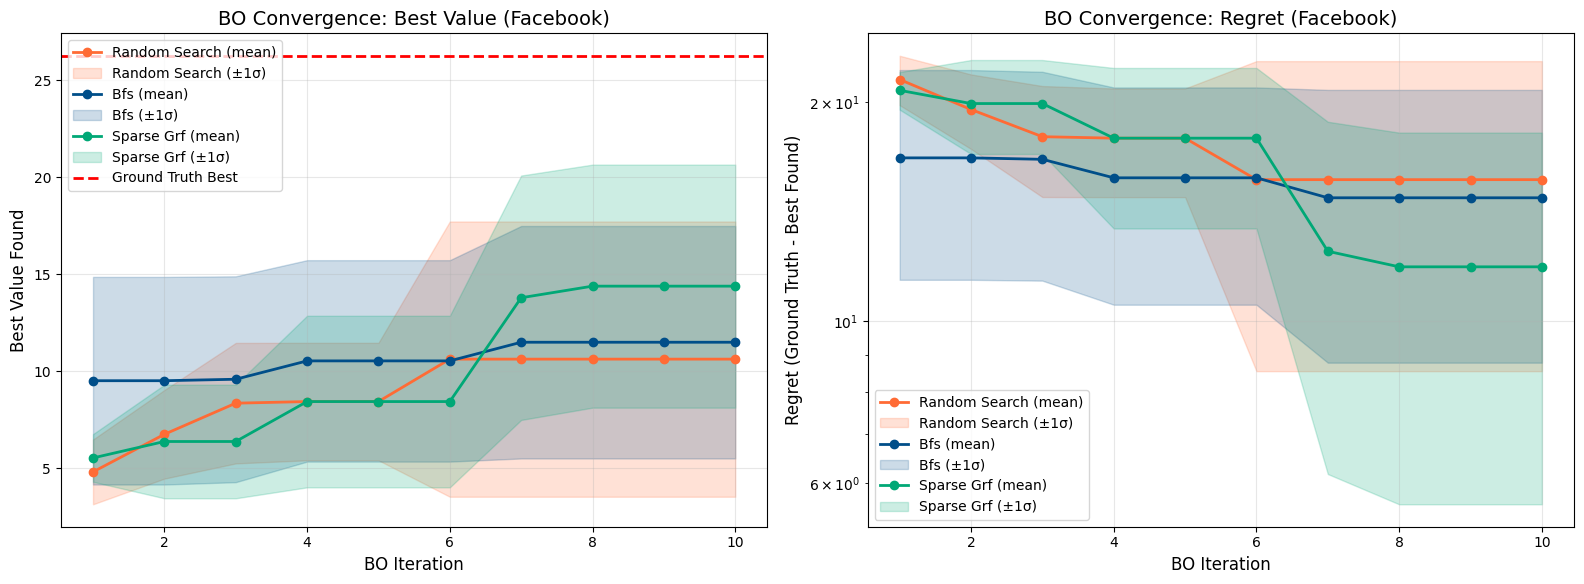


📊 Performance Summary for FACEBOOK

BFS:
  Final Best Value: 11.4932 ± 5.9938
  Final Regret:     14.7726 ± 5.9938
  Success Rates:
    Regret < 0.1:   0.0%
    Regret < 0.5:   0.0%
    Regret < 1.0:   0.0%
  Runs:             5

RANDOM SEARCH:
  Final Best Value: 10.6224 ± 7.0967
  Final Regret:     15.6433 ± 7.0967
  Success Rates:
    Regret < 0.1:   0.0%
    Regret < 0.5:   0.0%
    Regret < 1.0:   0.0%
  Runs:             250

SPARSE GRF:
  Final Best Value: 14.3856 ± 6.2659
  Final Regret:     11.8801 ± 6.2659
  Success Rates:
    Regret < 0.1:   0.0%
    Regret < 0.5:   0.0%
    Regret < 1.0:   0.0%
  Runs:             250

Dataset Statistics:
  Nodes:            22,470
  Edges:            170,912
  Density:          0.000677
  Ground Truth:     26.2658


In [17]:
def plot_convergence_analysis(results_df, figsize=(16, 6)):
    """Create comprehensive convergence plots"""
    
    if results_df is None or len(results_df) == 0:
        print("❌ No results to plot")
        return None
    
    # Set up plotting style
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 16
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Color mapping for algorithms
    colors = {
        'random_search': '#FF6B35',
        'bfs': '#004E89', 
        'sparse_grf': '#00A876'
    }
    
    # Plot 1: Best value convergence
    for algorithm in results_df['algorithm'].unique():
        algo_data = results_df[results_df['algorithm'] == algorithm]
        
        # Group by iteration and compute statistics across BO seeds
        mean_values = algo_data.groupby('iteration')['best_value'].mean()
        std_values = algo_data.groupby('iteration')['best_value'].std()
        
        color = colors.get(algorithm, '#333333')
        
        # Plot mean line
        ax1.plot(mean_values.index, mean_values.values, 
                marker='o', label=f'{algorithm.replace("_", " ").title()} (mean)', 
                linewidth=2, color=color)
        
        # Add shaded area for ±1 std
        ax1.fill_between(mean_values.index, 
                         mean_values.values - std_values.values,
                         mean_values.values + std_values.values, 
                         alpha=0.2, color=color, 
                         label=f'{algorithm.replace("_", " ").title()} (±1σ)')
    
    # Add ground truth line
    gt_best = results_df['ground_truth_best'].iloc[0]
    ax1.axhline(y=gt_best, color='red', linestyle='--', 
               label='Ground Truth Best', linewidth=2)
    
    ax1.set_xlabel('BO Iteration')
    ax1.set_ylabel('Best Value Found')
    ax1.set_title(f'BO Convergence: Best Value ({SELECTED_DATASET.title()})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Regret convergence
    for algorithm in results_df['algorithm'].unique():
        algo_data = results_df[results_df['algorithm'] == algorithm]
        
        # Group by iteration and compute statistics
        mean_regret = algo_data.groupby('iteration')['regret'].mean()
        std_regret = algo_data.groupby('iteration')['regret'].std()
        
        color = colors.get(algorithm, '#333333')
        
        # Plot mean line  
        ax2.plot(mean_regret.index, mean_regret.values, 
                marker='o', label=f'{algorithm.replace("_", " ").title()} (mean)', 
                linewidth=2, color=color)
        
        # Add shaded area for ±1 std
        ax2.fill_between(mean_regret.index,
                         mean_regret.values - std_regret.values,
                         mean_regret.values + std_regret.values,
                         alpha=0.2, color=color,
                         label=f'{algorithm.replace("_", " ").title()} (±1σ)')
    
    ax2.set_xlabel('BO Iteration')
    ax2.set_ylabel('Regret (Ground Truth - Best Found)')
    ax2.set_title(f'BO Convergence: Regret ({SELECTED_DATASET.title()})')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def print_performance_summary(results_df):
    """Print detailed performance statistics"""
    
    if results_df is None or len(results_df) == 0:
        print("❌ No results to summarize")
        return
    
    print(f"\n📊 Performance Summary for {SELECTED_DATASET.upper()}")
    print("=" * 60)
    
    final_iteration = results_df['iteration'].max()
    final_results = results_df[results_df['iteration'] == final_iteration]
    
    for algorithm in sorted(final_results['algorithm'].unique()):
        algo_final = final_results[final_results['algorithm'] == algorithm]
        
        mean_best = algo_final['best_value'].mean()
        std_best = algo_final['best_value'].std()
        mean_regret = algo_final['regret'].mean()
        std_regret = algo_final['regret'].std()
        
        # Success rates at different thresholds
        success_01 = (algo_final['regret'] < 0.1).mean() * 100
        success_05 = (algo_final['regret'] < 0.5).mean() * 100
        success_10 = (algo_final['regret'] < 1.0).mean() * 100
        
        print(f"\n{algorithm.replace('_', ' ').title().upper()}:")
        print(f"  Final Best Value: {mean_best:.4f} ± {std_best:.4f}")
        print(f"  Final Regret:     {mean_regret:.4f} ± {std_regret:.4f}")
        print(f"  Success Rates:")
        print(f"    Regret < 0.1:   {success_01:.1f}%")
        print(f"    Regret < 0.5:   {success_05:.1f}%") 
        print(f"    Regret < 1.0:   {success_10:.1f}%")
        print(f"  Runs:             {len(algo_final)}")
    
    # Dataset information
    print(f"\nDataset Statistics:")
    print(f"  Nodes:            {results_df['n_nodes'].iloc[0]:,}")
    print(f"  Edges:            {results_df['n_edges'].iloc[0]:,}")
    print(f"  Density:          {results_df['density'].iloc[0]:.6f}")
    print(f"  Ground Truth:     {results_df['ground_truth_best'].iloc[0]:.4f}")

# Run analysis if results are available
if 'bo_results_df' in globals() and bo_results_df is not None:
    print("📈 Generating convergence plots...")
    
    # Create convergence plots
    fig = plot_convergence_analysis(bo_results_df)
    if fig is not None:
        plt.show()
    
    # Print performance summary
    print_performance_summary(bo_results_df)
    
else:
    print("❌ No results available for analysis")
    print("   Run the experiment execution cell first")